# Build the speech model

Now that we have created the spectrogram images, its time to build the computer vision model. If you are following along with the different modules in this PyTorch learning path, then you should have a good understanding on how to create a computer vision model from the _"Introduction to Computer Vision with PyTorch"_ learn module. We will be using the `torchvision` package to build our vision model.  The `conv2d` convolutional neural network layer will be used to extract the unique features from the spectrogram image for each speech commands.

Lets import the packages we need to build the model.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchinfo import summary
import pandas as pd
import os

## Load Spectrogram images into a DataLoader for training

Here we provide the path to our image data and use PyTorch's `ImageFolder` dataset helper class to load the images into tensors.  We'll also normalize the images by resizing to 201x81 dimension.

In [2]:
data_path = './data/spectrograms' #looking in subfolder train

yes_no_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([transforms.Resize((201,81)),
                                  transforms.ToTensor()
                                  ])
)
print(yes_no_dataset)

Dataset ImageFolder
    Number of datapoints: 7985
    Root location: ./data/spectrograms
    StandardTransform
Transform: Compose(
               Resize(size=(201, 81), interpolation=bilinear)
               ToTensor()
           )


`ImageFolder` automatically creates the image class labels and indices based on the folders for each audio class.  We'll use the `class_to_idx` to view the class mapping for the image dataset.

<img alt="Folder class index diagram" src="4-model-1.png" width="60%"/>
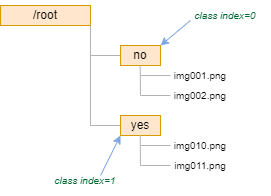

In [3]:
class_map=yes_no_dataset.class_to_idx

print("\nClass category and index of the images: {}\n".format(class_map))


Class category and index of the images: {'no': 0, 'yes': 1}



## Split the data for training and testing
We'll need to split the data to use 80% to train the model and 20% to test.

In [4]:
#split data to test and train
#use 80% to train
train_size = int(0.8 * len(yes_no_dataset))
test_size = len(yes_no_dataset) - train_size
yes_no_train_dataset, yes_no_test_dataset = torch.utils.data.random_split(yes_no_dataset, [train_size, test_size])

print("Training size:", len(yes_no_train_dataset))
print("Testing size:",len(yes_no_test_dataset))

Training size: 6388
Testing size: 1597


Since the dataset was randomly split, let's count the training data to verify that the data has a fairly even distribution between the images in the `yes` and 
`no` categories.

In [5]:
from collections import Counter

# labels in training set
train_classes = [label for _, label in yes_no_train_dataset]
Counter(train_classes)

Counter({1: 3197, 0: 3191})

- Load the data into the `DataLoader` and specify the batch size of how the data will be divided and loaded in the training iterations.  We'll also set the number of workers to specify the number of subprocesses to load the data.

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    yes_no_train_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    yes_no_test_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

- Let's take a look at what our training tensor looks like

In [7]:
td = train_dataloader.dataset[0][0][0][0]
print(td)

tensor([0.1412, 0.1529, 0.1608, 0.1882, 0.1843, 0.1647, 0.1529, 0.1725, 0.1686,
        0.1725, 0.1922, 0.1529, 0.1882, 0.1216, 0.2078, 0.1294, 0.1843, 0.2196,
        0.1569, 0.1529, 0.1529, 0.1255, 0.1255, 0.1569, 0.1725, 0.1176, 0.2078,
        0.1725, 0.1490, 0.1647, 0.1216, 0.1216, 0.1373, 0.2392, 0.1176, 0.1451,
        0.1255, 0.1216, 0.1333, 0.1843, 0.1412, 0.1412, 0.1529, 0.1451, 0.1451,
        0.1725, 0.1569, 0.1725, 0.1451, 0.1529, 0.2549, 0.1922, 0.1843, 0.1647,
        0.1647, 0.1647, 0.1686, 0.1569, 0.1725, 0.1961, 0.1569, 0.1686, 0.1686,
        0.1804, 0.1490, 0.1490, 0.1529, 0.1608, 0.1490, 0.1961, 0.1608, 0.2000,
        0.1882, 0.1569, 0.1725, 0.2275, 0.1647, 0.1804, 0.1725, 0.1569, 0.1529])


- Get GPU for training, else use CPU if GPU is not available

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cpu device


#### Create the convolutional neural network

<img alt="convolutional network diagram" src="4-model-2.png" width="60%"/>

We'll define our layers and parameters:

- `conv2d`: takes an input of 3 `channels` which represents RGB colors since our input images are in color. The 32 represents the number of feature map images produced from the convolutional layer after applying a `filter` on each image in a channel with a 5x5 `kernel` size and a stride of 1.  The `Max pooling` is set with a 2x2 kernel size to reduce the dimensions of the filtered images.  We apply the `ReLU` activation to replace the negative pixel values to zero.
- `conv2d`: takes the 32 output images from the previous convolutional layer as input. Then we increase the output number to 64 feature map images after a `filter` is applied on the 32 input images with a 5x5 `kernel` size and a stride of 1.  The `Max pooling` is set with a 2x2 kernel size to reduce the dimensions of the filtered images.  We apply the `ReLU` activation to replace the negative pixel values to zero.
- `dropout`: removes some of the features extracted from the `conv2d` layer with the ratio of 0.50 to prevent overfitting.
- `flatten`: converts features from the conv2d output image into the linear input layer.
- `Linear`: takes a number of 51136 features as input and sets the number of outputs from the network to be 50 logits. The next layer will take the 50 inputs and produces 2 logits in the output layer.   The `ReLU` activation function will be applied to the neurons across the linear network replace the negative values to zero. The 2 output values will be used to predict the classification `yes` or `no`.  
- `log_Softmax` activation function applied to the two output values to predict the probability of the audio classification.

After defining the CNN, we'll set the device to run it.
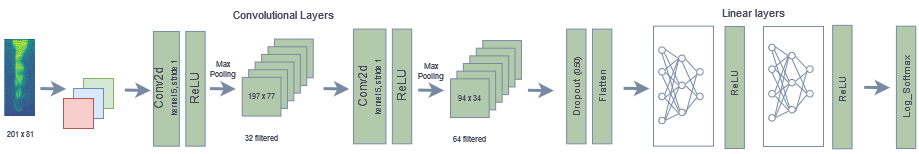

In [9]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51136, 50)
        self.fc2 = nn.Linear(50, 2)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)  

model = CNNet().to(device)

## Create Train and Test functions
- Here we will set the cost function, learning_rate, and optimizer. Then define the train and test functions that we will use to train and test the model using the CNN network.

In [10]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function

def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


# Create the validation/test function

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

## Train the model
- Now let's set the number of epochs and call our `train` and `test` functions for each iteration.  We'll iterate through the training network by the number of epochs.  As we train the model, we'll calculate the loss as it decreases during the training.  In addition, we'll display the accuracy as the optimization increases.

In [11]:
epochs = 15

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader, model, cost, optimizer)
    test(test_dataloader, model)
print('Done!')

Epoch 1
-------------------------------
loss: 0.694037  [    0/ 6388]
loss: 0.693824  [ 1500/ 6388]
loss: 0.693147  [ 3000/ 6388]
loss: 0.693147  [ 4500/ 6388]
loss: 0.622510  [ 6000/ 6388]

Test Error:
acc: 89.2%, avg loss: 0.017699

Epoch 2
-------------------------------
loss: 0.428135  [    0/ 6388]
loss: 0.220160  [ 1500/ 6388]
loss: 0.224018  [ 3000/ 6388]
loss: 0.208758  [ 4500/ 6388]
loss: 0.266951  [ 6000/ 6388]

Test Error:
acc: 92.0%, avg loss: 0.011517

Epoch 3
-------------------------------
loss: 0.211748  [    0/ 6388]
loss: 0.184088  [ 1500/ 6388]
loss: 0.085947  [ 3000/ 6388]
loss: 0.062023  [ 4500/ 6388]
loss: 0.132359  [ 6000/ 6388]

Test Error:
acc: 93.4%, avg loss: 0.009392

Epoch 4
-------------------------------
loss: 0.227769  [    0/ 6388]
loss: 0.054346  [ 1500/ 6388]
loss: 0.075164  [ 3000/ 6388]
loss: 0.285258  [ 4500/ 6388]
loss: 0.322772  [ 6000/ 6388]

Test Error:
acc: 94.6%, avg loss: 0.008388

Epoch 5
-------------------------------
loss: 0.063541  [   

- Let's look at the summary breakdown of the model architecture.  It shows the number of filters used for the feature extraction and image reduction from pooling for each convolutional layer.  Next, it shows input and output features used for classification in the linear layers.

In [12]:
summary(model, input_size=(15, 3, 201, 81))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [15, 32, 197, 77]         2,432
├─Conv2d: 1-2                            [15, 64, 94, 34]          51,264
├─Dropout2d: 1-3                         [15, 64, 94, 34]          --
├─Flatten: 1-4                           [15, 51136]               --
├─Linear: 1-5                            [15, 50]                  2,556,850
├─Linear: 1-6                            [15, 2]                   102
Total params: 2,610,648
Trainable params: 2,610,648
Non-trainable params: 0
Total mult-adds (M): 202.60
Input size (MB): 2.93
Forward/backward pass size (MB): 82.80
Params size (MB): 10.44
Estimated Total Size (MB): 96.17

 ## Test the model
 
Awesome! You should have got somewhere between a 93%-95% accuracy by the 15th epoch. Here we grab a batch from our test data and see how the model performs on the predicted vs the actual result. 

In [13]:
model.eval()
test_loss, correct = 0, 0
class_map = ['no', 'yes']

with torch.no_grad():
    for batch, (X, Y) in enumerate(test_dataloader):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        print("Predicted:\nclass_index={}, class_name= {}\n".format(pred[0].argmax(0),class_map[pred[0].argmax(0)]))
        print("Actual:\nclass_index={}, class_name= {}\n".format(Y[0],class_map[Y[0]]))
        break

Predicted:
class_index=0, class_name= no

Actual:
class_index=0, class_name= no

